# Statistical Methods - Assignment 3

All assignments are graded following the rubric on Canvas. In short, we are grading under the followings aspects: complete solution, explanation of assumptions, explanation of solution, clearness of plots, coding practices.

## Assignment 3:

|          |   Task 1    |    Task 2   |    Task 3   |    Task 4   |     Sum    |
|:--------:|:-----------:|:-----------:|:-----------:|:-----------:|:----------:|
| Solution |   10/ 10    |    8/ 10    |   6.5 / 10   |  5.5 / 10  |    30/ 40  |

- General comments: Great work! More comments below.

**Note that if you run the code in the current state, there may be errors in task 4, likely when you reach the cell that computes autocorrelation time.**

In [1]:
from astropy.io import fits
import pandas as pd
import scipy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.integrate as spint
import scipy.interpolate as spinterp
import lmfit
from lmfit import Minimizer, Parameters, report_fit
import emcee
import corner
from multiprocessing import Pool

**Global variables needed for the assignment**

In [2]:
Cluster_names = ['Hogg_4', 'NGC_2439', 'Berkeley_18']
Cluster_inibins = [50,60,40]

In [3]:
rho_vals = [0.013,0.013,0.008]
rc_vals = [700,200,200]
rt_vals = [2300,3100,2000]
c_vals = [1e-7,1e-7,1e-6]
ylims = [[0,100],[20,300],[0,100]]

In [4]:
G = 4.3e-3 #G in units of parsec/solar mass km/s^2
yrtos = 3.156e7
astom = 3.086e16
kpctom = 3.086e19
m_sun = 1.989e30
mastorad = 4.848e-9
mastom = 2e33

**Defining functions needed for various tasks**

In [5]:
def make_cluster(starsdf,ClusterName):

    '''
    This function creates a dataframe with all stars belonging to a particular cluster. It then adds a column for radial separation between stars
    where radial separation is given by the formula r = 3600 x sqrt((x-x')^2+(y-y')^2)

    Parameters:
    -----------
    1. starsdf - Pandas dataframe
                 Dataframe of stars
    2. ClusterName - string
                     Name of the cluster

    Returns:
    --------
    FinalClusterDf - Pandas dataframe
                     Dataframe with stars belonging to a cluster along with the radial separation for each star in arcseconds
    '''
    ClusterDf = starsdf[starsdf['Name'] == ClusterName]
    FinalClusterDf = ClusterDf.copy()
    RAmean = ClusterDf['RAdeg'].mean()
    DEmean = ClusterDf['DEdeg'].mean()
    FinalClusterDf['Rad_sep'] = 3600*np.sqrt((FinalClusterDf.loc[:,'RAdeg'] - RAmean)**2 + (FinalClusterDf.loc[:,'DEdeg'] - DEmean)**2)
    return FinalClusterDf

In [6]:
def create_subsamples(clusterdf, quantity, percentile1, percentile2):

    '''
    This function extracts part of a dataframe corresponding to different percentile ranges of a quantity (Gmag or proper motion).

    Parameters:
    ------------
    1. clusterdf: Pandas dataframe
                  Dataframe of stars
    2. quantity: string
                 quantity based on which the cluster is divided into subsamples
    3. percentile1: integer
                   lower limit on percentile range
    4. percentile2: integer
                    upper limmit on percentile range
    '''
    if (quantity == 'PM'):
        clusterdf['Mean Proper Motion'] = np.sqrt(clusterdf['pmRA']**2 + clusterdf['pmDE']**2)
        low_perc = np.percentile(clusterdf['Mean Proper Motion'], percentile1)
        high_perc = np.percentile(clusterdf['Mean Proper Motion'], percentile2)
        subsample = clusterdf[(clusterdf['Mean Proper Motion'] >= low_perc) & (clusterdf['Mean Proper Motion'] <= high_perc)]
        return subsample
    elif (quantity == 'Gmag'):
        low_perc = np.percentile(clusterdf['Gmag'], percentile1)
        high_perc = np.percentile(clusterdf['Gmag'], percentile2)
        subsample = clusterdf[(clusterdf['Gmag'] >= low_perc) & (clusterdf['Gmag'] <= high_perc)]
        return subsample

In [7]:
#copied from Prof. Uttley's github
def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays
    '''
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

In [8]:
def create_stardensprof(clusterdf,numbins,plotflag,pltitle):

    '''
    Creates a stellar density profile for a cluster.

    Parameters:
    -----------
    1. clusterdf - Pandas dataframe
                   Dataframe of stars
    2. numbins - integer
                 initial number of bins for stellar density histogram
    3. plotflag - integer
                  flag variable to decide when to plot stellar density profile
    4. pltitle - string
                 title for stellar density profile

    Returns:
    ---------
    1. Fincounts - numpy.ndarray
                  stellar density histogram counts after rebinning to a minimum number of counts per bin
    2. Finedges - numpy.ndarray
                  stellar density histogram bin edges after rebinning to a minimum number of counts per bin
    '''
    MinR = clusterdf['Rad_sep'].min()
    MaxR = clusterdf['Rad_sep'].max()
    counts, edges = np.histogram(clusterdf['Rad_sep'], bins=numbins, range=[MinR,MaxR], density=False)
    mincounts = 20
    Fincounts, Finedges = histrebin(mincounts, counts, edges)
    binareas = np.pi * np.diff((Finedges)**2) #area of annular region between histogram bins
    Stellar_density = Fincounts/ binareas
    Dens_error = np.sqrt(Fincounts)/ binareas #error for Poisson distribution of histogram counts
    Radii = (Finedges[:-1]+Finedges[1:])/2 #Radius is midpoint of an annular region
    if plotflag == 1:
        plt.figure()
        plt.errorbar(Radii, Stellar_density, xerr = np.diff(Finedges)/2,yerr=Dens_error, fmt='o')
        plt.xlabel("Radius (arcsec)", fontsize=12)
        plt.ylabel("Stellar number density ($arcsec^{-2}$)", fontsize=12)
        plt.tick_params(labelsize=10)
        plt.yscale('log')
        plt.xscale('log')
        plt.title(pltitle)
        plt.xlim(MinR,MaxR)
        plt.show()               
    return Fincounts, Finedges

In [9]:
def King_profile(radius, params):

    '''
    Computes the model used to fit the stellar density profile which is a variant of the King model. 

    Parameters:
    -----------
    1. radius: float/list
               radius at which king model is computed
    2. params: dictionary
               inital parameter values for the King model

    Returns:
    ---------
    numpy.ndarray of values for the king model based on initial paramters and radii provided
    '''
    v = params.valuesdict()
    if(isinstance(radius,float)):
        if(radius <= v['r_t']):
            return np.array((v['rho_0']*(1/(np.sqrt(1 + (radius/v['r_c'])**2)) - 1/(np.sqrt(1 + (v['r_t']/v['r_c'])**2)))**2 + v['c']))
        else:
            return np.array(v['c'])
    else:        
        rho_king = []
        for r in radius:
            if (r <=  v['r_t']):
                rho_king.append( v['rho_0']*(1/(np.sqrt(1 + (r/v['r_c'])**2)) - 1/(np.sqrt(1 + (v['r_t']/v['r_c'])**2)))**2 + v['c'] )
            else :
                rho_king.append( v['c'] )   
        return np.array(rho_king)

In [10]:
#copied from Prof. Uttley's github and modified to integrate over an annular bin and normalize with bin area
def model_bin(xbins, model, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        #x2 = lambda x: 2 * np.pi * x
        ymod[i], ymoderr = spint.quad(lambda x: 2*np.pi*x*model(x, params),xbins[i],xbins[i+1])
        #ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        ymod[i] = ymod[i]/(np.pi*((xbins[i+1])**2-(xbins[i])**2))
    return ymod

In [11]:
#copied from Prof. Uttley's github
def lmf_lsq_binresid(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
            if i == 0:
                resid = (ydata[i]-model_bin(xdata[i],model,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin(xdata[i],model,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

In [12]:
#copied from Prof. Uttley's github
def grid1d_binchisqmin(a_name,a_range,a_steps,parm,model,xdata,ydata,yerrs):
    '''Uses lmfit. Finds best the fit and then carries out chisq minimisation for a 1D grid of fixed 
       parameters, but using a binned model suitable for binned counts data
       Input: 
            a_name - string, name of 'a' parameter (in input Parameters object parm) to use for grid.
            a_range, a_steps - range (tuple or list) and number of steps for grid.
            parm - lmfit Parameters object for model to be fitted.
            model - name of model function to be fitted.
            xdata, ydata, yerrs - lists of data x, y and y-error arrays (as for the lmf_lsq_resid function)
        Output: 
            a_best - best-fitting value for 'a'
            minchisq - minimum chi-squared (for a_best)
            a_grid - grid of 'a' values used to obtain fits
            chisq_grid - grid of chi-squared values corresponding to a_grid
    '''
    a_grid = np.linspace(a_range[0],a_range[1],a_steps)
    chisq_grid = np.zeros(len(a_grid))
    # First obtain best-fitting value for 'a' and corresponding chi-squared
    set_function = Minimizer(lmf_lsq_binresid, parm, fcn_args=(xdata, ydata, yerrs, model, True),
                             nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    minchisq = result.chisqr
    a_best = result.params.valuesdict()[a_name]
    # Now fit for each 'a' in the grid, to do so we use the .add() method for the Parameters object
    # to replace the value of a_name with the value for the grid, setting vary=False to freeze it
    # so it cannot vary in the fit (only the other parameters will be left to vary)
    for i, a_val in enumerate(a_grid):
        parm.add(a_name,value=a_val,vary=False)
        set_function = Minimizer(lmf_lsq_binresid, parm, fcn_args=(xdata, ydata, yerrs, model, True), 
                                                                nan_policy='omit')
        result = set_function.minimize(method = 'leastsq')
        chisq_grid[i] = result.chisqr
        
    return a_best, minchisq, a_grid, chisq_grid 

def calc_error_chisq(delchisq,a_best,minchisq,a_grid,chisq_grid):
    '''Function to return upper and lower values of a parameter 'a' for a given delta-chi-squared
       Input:
           delchisq - the delta-chi-squared for the confidence interval required (e.g. 1 for 1-sigma error)
           a_best, minchisq - best-fitting value for 'a' and corresponding chi-squared minimum
           a_grid, chisq_grid - grid of 'a' and corresponding chi-squared values used for interpolation'''
    # First interpolate over the grid for values > a_best and find upper interval bound
    chisq_interp_upper = spinterp.interp1d(chisq_grid[a_grid > a_best],a_grid[a_grid > a_best])
    a_upper = chisq_interp_upper(minchisq+delchisq)
    # Interpolate for values <= a_best to find lower interval bound
    chisq_interp_lower = spinterp.interp1d(chisq_grid[a_grid <= a_best],a_grid[a_grid <= a_best])
    a_lower = chisq_interp_lower(minchisq+delchisq)  
    return [a_lower,a_upper]

In [13]:
#copied from Prof. Uttley's github
def plot_profile_model(rbins,stardens,stardens_err,stardens_model):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    radii = (rbins[1:]+rbins[:-1])/2
    bwidths = np.diff(rbins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(radii, stardens, xerr=bwidths/2., yerr=stardens_err, fmt='o')
    model_hist, edges, patches = ax1.hist(radii, bins=rbins, weights=stardens_model, 
                                      density=False, histtype='step')
    ax2.errorbar(radii, stardens/stardens_model, xerr=bwidths/2., yerr=stardens_err/stardens_model, fmt='o')
    ax2.set_xlabel("Radius (arcsec)", fontsize=12)
    ax1.set_ylabel("Stellar density ($arcsec^{-2}$)", fontsize=12)
    ax2.set_ylabel("data/model", fontsize=14)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=10)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=10)
    ax1.set_yscale('log')
    #ax2.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.set_xlim(rbins[0],rbins[-1]) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    plt.show()

In [14]:
#copied from Prof. Uttley's github
def model_bin_mult(xbins, model, i_data, params):
    '''General function for integrating the input model over bins defined by contiguous (no gaps) 
        bin edges, xbins.
       Inputs:
           xbins - x bin edges.
           i_data - the dataset being considered (determines which parameters to use in the model)
           model, params - the model name and associated Parameters object.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(xbins)-1)
    for i, xval in enumerate(xbins[:-1]):
        #x2 = lambda x: 2 * np.pi * x
        ymod[i], ymoderr = spint.quad(lambda x: 2*np.pi*x*model(x, i_data, params),xbins[i],xbins[i+1])
        #ymod[i] = ymod[i]/(xbins[i+1]-xbins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        ymod[i] = ymod[i]/(np.pi*((xbins[i+1])**2-(xbins[i])**2))
    return ymod
    
def lmf_lsq_binresid_mult(params,xdata,ydata,yerrs,model,output_resid=True):
    '''lmfit objective function to calculate and return residual array or model y-values for
        binned data where the xdata are the input bin edges and ydata are the densities (integral over bin
        divided by bin width).
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata, yerrs - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y-value array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (residuals) is
                        required output, otherwise a list of model y-value arrays (corresponding to the 
                        input x-data list) is returned.
        Output: if output_resid==True, returns a residual array of (y_i-y_model(x_i))/yerr_i which is
            concatenated into a single array for all input data errors (i.e. length is n1+n2 in 
            the example above). If output_resid==False, returns a list of y-model arrays (one per input x-array)'''
    if output_resid == True:
        for i, xvals in enumerate(xdata):  # loop through each input dataset and record residual array
                     # Note that we identify the dataset by counting from 1 not 0, this is just the 
                    # standard we will use for naming the parameters.
            if i == 0:
                resid = (ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i]
            else:
                resid = np.append(resid,(ydata[i]-model_bin_mult(xdata[i],model,i+1,params))/yerrs[i])
        return resid
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin_mult(xdata[i],model,i+1,params))
        return ymodel

In [15]:
def pl_model_mult(radius, i_data, params):
    '''King model function to fit multiple datasets. 
       Inputs:
           radius - input radius value(s) (can be list or single value).
           i_data - Index of dataset
           params - lmfit Parameters object'''
    v = params.valuesdict()
    if(isinstance(radius,float)):
        if(radius <= v['r_t'+str(i_data)]):
            return np.array((v['rho_0'+str(i_data)]*(1/(np.sqrt(1 + (radius/v['r_c'+str(i_data)])**2)) - 1/(np.sqrt(1 + (v['r_t'+str(i_data)]/v['r_c'+str(i_data)])**2)))**2 + v['c'+str(i_data)]))
        else:
            return np.array(v['c'+str(i_data)])
    else:        
        rho_king = []
        for r in radius:
            if (r <=  v['r_t'+str(i_data)]):
                rho_king.append( v['rho_0'+str(i_data)]*(1/(np.sqrt(1 + (r/v['r_c'+str(i_data)])**2)) - 1/(np.sqrt(1 + (v['r_t'+str(i_data)]/v['r_c'+str(i_data)])**2)))**2 + v['c'+str(i_data)] )
            else :
                rho_king.append( v['c'+str(i_data)] )   
        return np.array(rho_king)

In [16]:
#Procedure followed is based on Prof. Uttley's github
def comp_nullaltern(clusternum,subsample1,subsample2):

    '''
    This function compares 2 subsamples of a cluster (based on proper motion/Gmag) and analyzes the dependence of king model parameters on 
    the quantity.

    Parameters:
    -----------
    1. clusternum - integer
                    cluster number (in the 3 clusters I am analyzing)
    2. subsample1 - Pandas dataframe
                    Cluster dataframe for first percentile range of PM/Gmag
    3. subsample2 - Pandas dataframe
                    Cluster dataframe for second percentile range of PM/Gmag
    '''
    samp1counts, samp1edges = create_stardensprof(subsample1,50,0,'no title')
    samp1dens = samp1counts/(np.pi*(np.diff(samp1edges**2)))
    samp1errors = np.sqrt(samp1counts)/(np.pi*(np.diff(samp1edges**2)))
    samp2counts, samp2edges = create_stardensprof(subsample2,50,0,'no title')
    samp2dens = samp2counts/(np.pi*(np.diff(samp2edges**2)))
    samp2errors = np.sqrt(samp2counts)/(np.pi*(np.diff(samp2edges**2)))
    Params1 = Parameters()
    Params2 = Parameters()
    Params3 = Parameters()
    Params4 = Parameters()
    Params1.add_many(('rho_01',rho_vals[clusternum-1]),('r_c1',rc_vals[clusternum-1]),('r_t1', rt_vals[clusternum-1]),('c1',c_vals[clusternum-1]),('rho_02',rho_vals[clusternum-1],True,None,None,'rho_01'),('r_c2',rc_vals[clusternum-1],True,None,None,'r_c1'),('r_t2',rt_vals[clusternum-1],True,None,None,'r_t1'),('c2',c_vals[clusternum-1]))
    Params2.add_many(('rho_01',rho_vals[clusternum-1]),('r_c1',rc_vals[clusternum-1]),('r_t1', rt_vals[clusternum-1]),('c1',c_vals[clusternum-1]),('rho_02',rho_vals[clusternum-1]),('r_c2',rc_vals[clusternum-1],True,None,None,'r_c1'),('r_t2',rt_vals[clusternum-1],True,None,None,'r_t1'),('c2',c_vals[clusternum-1]))
    Params3.add_many(('rho_01',rho_vals[clusternum-1]),('r_c1',rc_vals[clusternum-1]),('r_t1', rt_vals[clusternum-1]),('c1',c_vals[clusternum-1]),('rho_02',rho_vals[clusternum-1]),('r_c2',rc_vals[clusternum-1]),('r_t2',rt_vals[clusternum-1],True,None,None,'r_t1'),('c2',c_vals[clusternum-1]))
    Params4.add_many(('rho_01',rho_vals[clusternum-1]),('r_c1',rc_vals[clusternum-1]),('r_t1', rt_vals[clusternum-1]),('c1',c_vals[clusternum-1]),('rho_02',rho_vals[clusternum-1]),('r_c2',rc_vals[clusternum-1]),('r_t2',rt_vals[clusternum-1]),('c2',c_vals[clusternum-1]))
    
    model = pl_model_mult
    output_resid = True
    xdata = [samp1edges,samp2edges]
    ydata = [samp1dens, samp2dens]
    yerrs = [samp1errors, samp2errors]
    set_function = Minimizer(lmf_lsq_binresid_mult, Params1, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result_null = set_function.minimize(method = 'leastsq')
    #In the null hypothesis, we assume that all parameters are tied
    print("For null hypothesis, minimum Chi-squared = "+str(result_null.chisqr)+" for "+str(result_null.nfree)+" d.o.f.") 
    print("The goodness of fit is: ",sts.chi2.sf(result_null.chisqr,df=result_null.nfree))

    #We then untie one parameter at a time
    print('\nDependence of normalization:')
    model = pl_model_mult
    output_resid = True
    xdata = [samp1edges, samp2edges]
    ydata = [samp1dens, samp2dens]
    yerrs = [samp1errors, samp2errors]
    set_function = Minimizer(lmf_lsq_binresid_mult, Params2, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result_altern_rho = set_function.minimize(method = 'leastsq')
    #report_fit(result_altern)
    print("For alternate hypothesis, minimum Chi-squared = "+str(result_altern_rho.chisqr)+" for "+str(result_altern_rho.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sts.chi2.sf(result_altern_rho.chisqr,df=result_altern_rho.nfree))

    m = result_null.nfree-result_altern_rho.nfree
    deltachisq = result_null.chisqr-result_altern_rho.chisqr
    print("p-value for our delta-chi-squared: ",sts.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")

    print('\nDependence of core radius:')
    model = pl_model_mult
    output_resid = True
    xdata = [samp1edges, samp2edges]
    ydata = [samp1dens, samp2dens]
    yerrs = [samp1errors, samp2errors]
    set_function = Minimizer(lmf_lsq_binresid_mult, Params3, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result_altern_rc = set_function.minimize(method = 'leastsq')
    #report_fit(result_altern)
    print("For alternate hypothesis, minimum Chi-squared = "+str(result_altern_rc.chisqr)+" for "+str(result_altern_rc.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sts.chi2.sf(result_altern_rc.chisqr,df=result_altern_rc.nfree))

    m = result_null.nfree-result_altern_rc.nfree
    deltachisq = result_null.chisqr-result_altern_rc.chisqr
    print("p-value for our delta-chi-squared: ",sts.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")
    
    print('\nDependence of tidal radius:')
    model = pl_model_mult
    output_resid = True
    xdata = [samp1edges,samp2edges]
    ydata = [samp1dens, samp2dens]
    yerrs = [samp1errors, samp2errors]
    set_function = Minimizer(lmf_lsq_binresid_mult, Params4, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
    result_altern_rt = set_function.minimize(method = 'leastsq')
    #report_fit(result_altern)
    print("For alternate hypothesis, minimum Chi-squared = "+str(result_altern_rt.chisqr)+" for "+str(result_altern_rt.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sts.chi2.sf(result_altern_rt.chisqr,df=result_altern_rt.nfree))

    m = result_null.nfree-result_altern_rt.nfree
    deltachisq = result_null.chisqr-result_altern_rt.chisqr
    print("p-value for our delta-chi-squared: ",sts.chi2.sf(deltachisq,df=m),"for",m,"fewer constraints.")


In [17]:
def real_posterior(newstardf):
    '''
    Computes the Bayesian posterior pdf for the distance (in kpc) to a cluster assuming a more realistic prior pdf given by 
    𝑑^2 e^-(d/L) where L = 1 kpc.
    
    Parameter:
    -----------
    1. newstardf: Pandas dataframe
                  Dataframe containing information of stars belonging to 1 cluster

    Returns:
    ---------
    1. logpos: numpy.ndarray
               Logarithm of posterior probability density function calculated using Bayes' theorem for distance to the cluster corresponding to newstardf
               assuming a realistic prior
    '''
    
    d_range = np.linspace(np.min(newstardf['Distance']),np.max(newstardf['Distance']),604)
    real_prior = d_range**2 * np.exp(-np.abs(d_range)) 
    #not taking absolute values results in large negative distance values for some clusters with negative parallax values
    Plx_array = np.array(newstardf['Plx'])
    e_array = np.array(newstardf['e_Plx'])
    res_ePlx = e_array.reshape(len(e_array),1)
    res_Plx = Plx_array.reshape(len(Plx_array),1)
    Real_loglikel_prior = np.sum((sts.norm.logpdf(res_Plx, loc=1/d_range, scale = res_ePlx)),axis=0) + np.log(real_prior)
    Real_likel_prior = np.exp(Real_loglikel_prior-np.amax(Real_loglikel_prior))
    Real_likel_prior_int = spint.simpson(Real_likel_prior, x = d_range)
    Real_posterior_pdf = Real_likel_prior/Real_likel_prior_int
    #plt.plot(d_range,Real_posterior_pdf)
    #plt.plot(d_range*mastom,Real_posterior_pdf)
    logpos = np.log(Real_posterior_pdf)
    #plt.plot(d_range,logpos)
    return logpos

In [18]:
#copied from previous assignment
def d_prior(Cluster):
    '''
    This is the function called in the main part of the code for task 4 to obtain posterior for distance. It calls real_posterior.

    Parameters:
    ------------
    1. Cluster:
    Returns:                 
    ---------
    1. d_range : numpy.ndarray
                 Range of distances based on cluster parallaxes
    2. Log_real_posterior : numpy.ndarray
                            Logarithm of posterior probability of distance to cluster
    '''
    updatedstardf = Cluster.copy()
    Clustername = updatedstardf.iloc[0,0]
    updatedstardf['Plx'] = updatedstardf['Plx'] + 0.029 #zero point offset
    updatedstardf['Distance'] = 1/updatedstardf['Plx']
    #updatedstardf['Distance'] = updatedstardf['Distance'] * mastom
    d_range = np.linspace(np.min(updatedstardf['Distance']),np.max(updatedstardf['Distance']),604)
    Log_Real_posterior = real_posterior(updatedstardf)
    #Mode_real_index = np.argmax(np.array(Real_posterior))
    #Mode_real = d_range[Mode_real_index]
    #d_range = d_range * mastom
    return d_range, Log_Real_posterior

In [19]:
def varpm_normprior(Cluster):

    '''
    Computes the prior for variance in proper motion, needed for MCMC. It calculates this using the proper motions in RA and DE, the mean proper motion
    and propogation of errors.

    Parameter:
    ----------
    1. Cluster - Pandas dataframe
                 Stars belonging to a cluster

    Returns:
    --------
    1. varpm_normaldist - numpy.ndarray
                          Log-normal distribution of proper motion variance
    '''
    n = len(Cluster)
    Mean_PM_RA = Cluster['pmRA'].mean()
    Mean_PM_DE = Cluster['pmDE'].mean()
    Cluster['var_PM'] = (Cluster['pmRA']-Mean_PM_RA)**2 + (Cluster['pmDE']-Mean_PM_DE)**2
    Mean_varPM = np.sum((Cluster['pmRA']-Mean_PM_RA)**2)/(n-1) + np.sum((Cluster['pmDE']-Mean_PM_DE)**2)/(n-1)
    #print(Mean_varPM)
    #print(Cluster['var_PM'])
    varPM_array = np.array(Cluster['var_PM'])
    Std_varPM = np.std(varPM_array)
    #print(Std_varPM)
    varpm_normaldist = sts.norm.logpdf(varPM_array,loc = Mean_varPM, scale = Std_varPM)
    #plt.plot(np.linspace(np.min(varPM_array),np.max(varPM_array),n),varpm_normaldist)
    #plt.plot(varPM_array,varpm_normaldist)
    return varpm_normaldist

In [20]:
def M_prior(Cluster):
    '''
    Returns the logarithm of the number of stars in the cluster (this is roughly the mass of the cluster in solar masses)
    '''
    Mprior = len(Cluster)
    return np.log(Mprior)

**Initial Setup**

In [22]:
#copied from assignment
#dr3stars = fits.open(r'C:\Users\ragha\Downloads\gaiadr3_cluster_stars.fits')
dr3stars = fits.open('gaiadr3_cluster_stars.fits')
dr3stars.info()
#print(dr3stars[1].columns)
stars = pd.DataFrame(dr3stars[1].data)
stars['Name'] = stars['Name'].str.strip()

Filename: gaiadr3_cluster_stars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      93   ()      
  1  members.dat    1 TableHDU       331   1291929R x 56C   [A20, I4, I19, I1, F10.8, F12.8, F10.8, F12.8, F10.8, F12.8, E11.4, E11.4, F10.8, E11.4, F10.8, E11.4, F10.8, F11.8, F11.8, E11.4, E11.4, E11.4, E11.4, E11.4, E11.4, I2, F12.8, F10.7, F11.8, F10.8, F19.8, F16.8, F18.8, F17.8, F18.8, F17.8, F10.7, F10.7, F10.7, E11.4, E11.4, E11.4, E9.3, F12.8, F4.1, F6.1, F5.1, F11.7, F11.8, F6.1, F12.7, F13.8, F5.1, A13, I1, I1]   


**Assignment task 1**

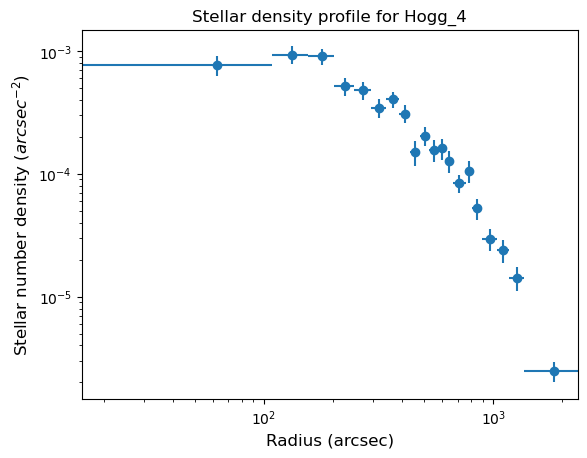

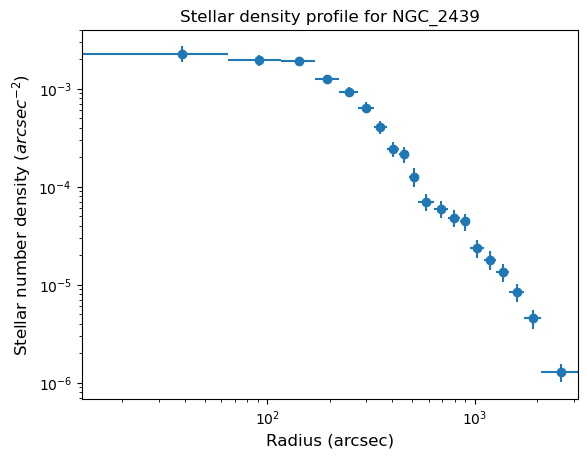

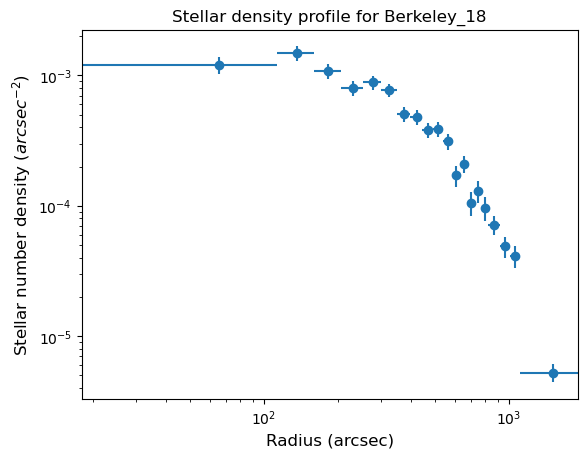

In [23]:
for i in range(len(Cluster_names)):
    Cluster = make_cluster(stars,Cluster_names[i])
    counts, edges = create_stardensprof(Cluster,Cluster_inibins[i],1,'Stellar density profile for '+Cluster_names[i])
    dens = counts/(np.pi*(np.diff(edges**2)))
    errors = np.sqrt(counts)/(np.pi*(np.diff(edges**2)))

**Comments on Task 1**
<br>
Above are stellar number density profiles of Hogg_4, NGC_2439 and Berkeley_18 in log-log scale. The minimum number of counts per bin for the histograms are 20. The Y axis errorbars are Poisson distribution errors, given by the square root of the counts in a bin, since within a bin, the counts are independently sampled at a "constant rate" and therefore follow the Poisson distribution. There are no formal X axis errors, but I have shown the bin widths as X errorbars. 
We see that the three clusters have roughly the same profiles, flat initially and a drop-off after a point that corresponds to the core radius of the cluster. The stellar densities all range between about 10^-6 to a few thousand stars/arcsec. The profiles of Hogg_4 and Berkeley_18 resemble each other closely, while NGC_2439 has an additional bump at about 500 arcsec. This might just be the nature of the data, and may be a reason the King profile doesn't fit it as well as it does the other two.

*Eleonora*:
- Task1
- task completion 5/5 & task quality 5/5
- tot 10/10

**Assignment Task 2**

 King model fit details for Hogg_4
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 20
    # variables        = 4
    chi-square         = 18.8555195
    reduced chi-square = 1.17846997
    Akaike info crit   = 6.82146820
    Bayesian info crit = 10.8043973
[[Variables]]
    rho_0:  0.00129561 +/- 1.2519e-04 (9.66%) (init = 0.013)
    r_c:    298.898805 +/- 39.2866201 (13.14%) (init = 700)
    r_t:    2278.15140 +/- 435.603865 (19.12%) (init = 2300)
    c:      6.1033e-07 +/- 1.6287e-06 (266.86%) (init = 1e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t, c)     = -0.9420
    C(r_c, r_t)   = -0.7878
    C(r_c, c)     = +0.6746
    C(rho_0, r_c) = -0.3163
    C(rho_0, c)   = +0.2851
    C(rho_0, r_t) = -0.2507
Minimum Chi-squared = 18.855519515082058 for 16 d.o.f.
The goodness of fit is:  0.27622665729388446




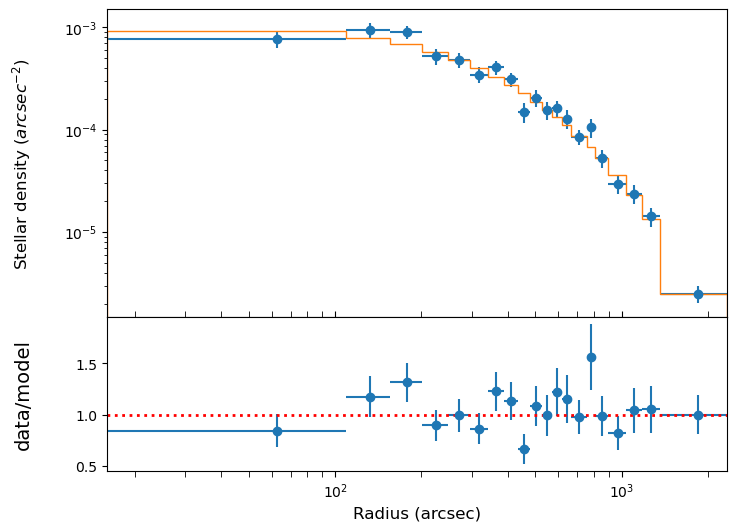

Parameter ranges for grid: [[0.0007948435069864589, 0.001796368953141779], [141.752324650469, 456.04528523452603], [535.7359442893728, 4020.5668613537555], [-5.90466836081623e-06, 7.125331455918459e-06]]
MLE rho_0: 0.001 with errors: [-0.  0.]
MLE r_c: 237.926 with errors: [-23.355  27.331]
MLE r_t: 1378.991 with errors: [-34.104  31.214]


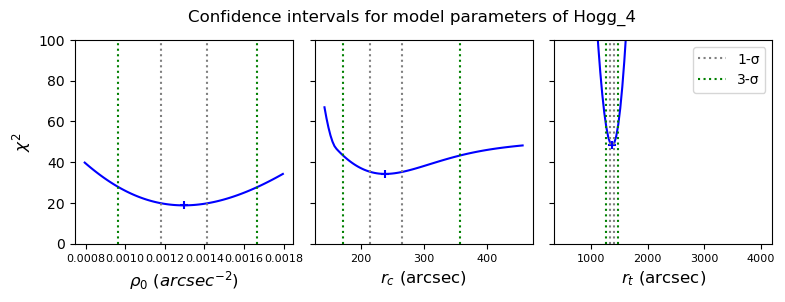

 King model fit details for NGC_2439
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 20
    # variables        = 4
    chi-square         = 42.1913566
    reduced chi-square = 2.63695979
    Akaike info crit   = 22.9296622
    Bayesian info crit = 26.9125912
[[Variables]]
    rho_0:  0.00364883 +/- 6.3377e-04 (17.37%) (init = 0.013)
    r_c:    132.271682 +/- 17.8278673 (13.48%) (init = 200)
    r_t:    3032.48872 +/- 614.706238 (20.27%) (init = 3100)
    c:      1.0918e-06 +/- 6.7926e-07 (62.22%) (init = 1e-07)
[[Correlations]] (unreported correlations are < 0.100)
    C(rho_0, r_c) = -0.8481
    C(r_t, c)     = -0.7764
    C(r_c, r_t)   = -0.5859
    C(r_c, c)     = +0.3916
    C(rho_0, r_t) = +0.1854
    C(rho_0, c)   = -0.1061
Minimum Chi-squared = 42.19135664463098 for 16 d.o.f.
The goodness of fit is:  0.00036948219699001807




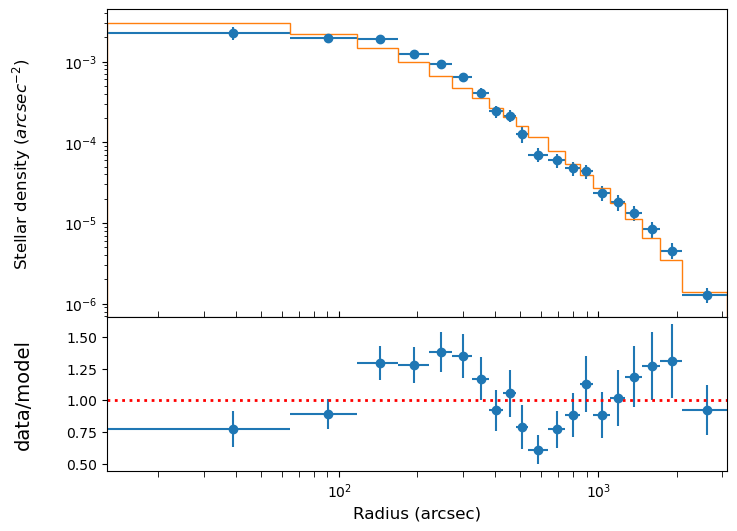

Parameter ranges for grid: [[0.001113769359680683, 0.006183891158569257], [60.9602125995747, 203.58315099160822], [700, 1000], [-1.6252665769926684e-06, 3.8087950003144156e-06]]
MLE rho_0: 0.004 with errors: [-0.  0.]
MLE r_c: 92.616 with errors: [-3.973  3.878]
MLE r_t: 843.171 with errors: [-24.74   24.869]


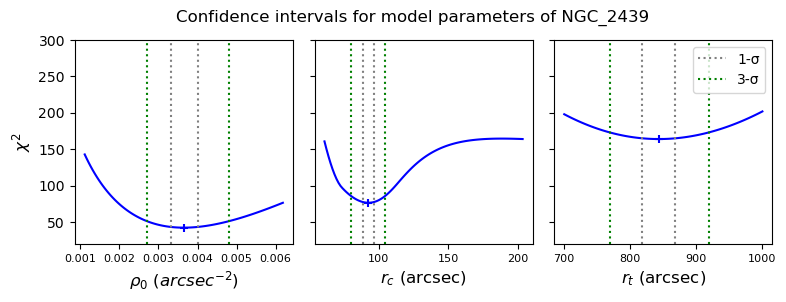

 King model fit details for Berkeley_18
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 20
    # variables        = 4
    chi-square         = 18.0717678
    reduced chi-square = 1.12948549
    Akaike info crit   = 5.97237310
    Bayesian info crit = 9.95530219
[[Variables]]
    rho_0:  0.00232416 +/- 2.0383e-04 (8.77%) (init = 0.008)
    r_c:    364.909557 +/- 43.0127425 (11.79%) (init = 200)
    r_t:    1706.90737 +/- 228.112006 (13.36%) (init = 2000)
    c:      1.0655e-06 +/- 2.9034e-06 (272.48%) (init = 1e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_t, c)     = -0.9427
    C(r_c, r_t)   = -0.8422
    C(rho_0, r_t) = -0.7805
    C(rho_0, c)   = +0.7555
    C(r_c, c)     = +0.7291
    C(rho_0, r_c) = +0.4093
Minimum Chi-squared = 18.071767762388117 for 16 d.o.f.
The goodness of fit is:  0.3197111721922048




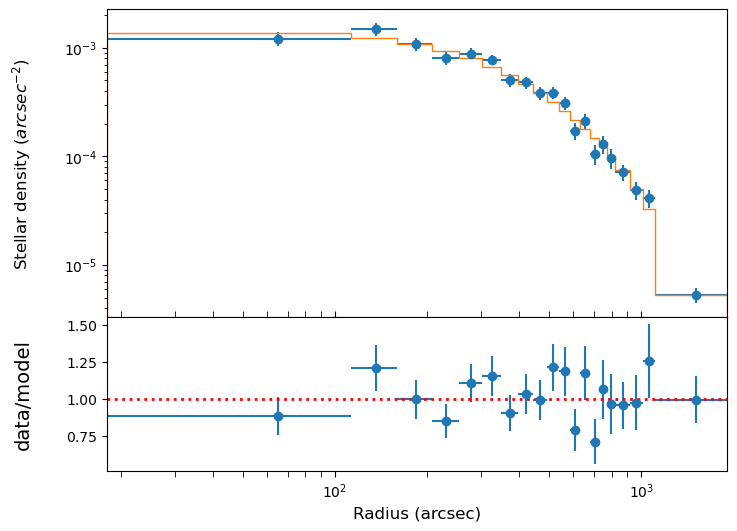

Parameter ranges for grid: [[0.0015088213435382964, 0.0031395001046309505], [192.85858635166167, 536.9605266639288], [794.4593487677328, 2619.355400346244], [0, 1.2679103941134993e-05]]
MLE rho_0: 0.002 with errors: [-0.  0.]
MLE r_c: 481.042 with errors: [-41.705  42.091]
MLE r_t: 1284.884 with errors: [-18.407  18.366]


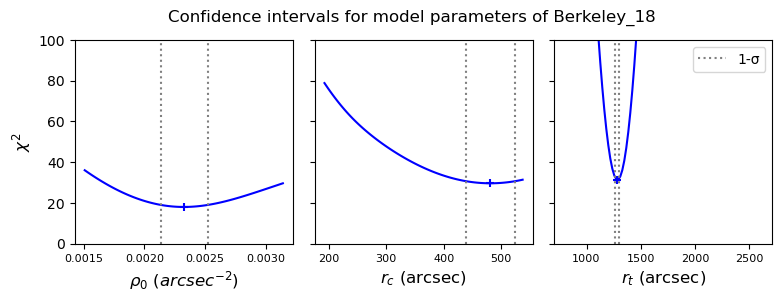

In [24]:
for j in range(len(Cluster_names)):
    Cluster = make_cluster(stars,Cluster_names[j])
    counts, edges = create_stardensprof(Cluster,Cluster_inibins[j],0,'Stellar density profile for '+Cluster_names[j])
    dens = counts/(np.pi*(np.diff(edges**2)))
    errors = np.sqrt(counts)/(np.pi*(np.diff(edges**2)))
    Cluster_params = Parameters()
    Cluster_params.add_many(('rho_0',rho_vals[j]),('r_c',rc_vals[j]),('r_t',rt_vals[j]),('c',c_vals[j]))
    model = King_profile
    output_resid = True
    xdata = [edges]
    ydata = [dens]
    yerrs = [errors]
    set_function = Minimizer(lmf_lsq_binresid, Cluster_params, fcn_args=(xdata, ydata, yerrs, model, output_resid), nan_policy='omit')
    result = set_function.minimize(method = 'leastsq')
    print("\033[1m King model fit details for "+Cluster_names[j]+"\033[0m")
    report_fit(result)
    print("Minimum Chi-squared = "+str(result.chisqr)+" for "+str(result.nfree)+" d.o.f.")
    print("The goodness of fit is: ",sts.chi2.sf(result.chisqr,df=result.nfree))
    print('\n')

    # To calculate the best-fitting model values, use the parameters of the best fit output
    # from the fit, result.params and set output_resid=false to output a list of model y-values:
    model_vals = lmf_lsq_binresid(result.params,xdata,ydata,yerrs,model,output_resid=False)
    # Now plot the data and model and residuals
    # The plotting function we defined takes the array of model values, so we must
    # specify the index for the model_vals list, to provide this array
    plot_profile_model(edges,dens,errors,model_vals[0]) 

    model = King_profile
    par_names = ['rho_0','r_c','r_t','c'] # Names of parameters in Parameters object
    n_steps = 100  # Number of steps in our grids
    # Ranges for each parameter - should aim for a few times times 1-sigma error estimated from covariance
    # We can specify by hand or use the values from the original minimize result if available:
    par_ranges = []
    for i, par_name in enumerate(par_names):
        # range min/max are best-fitting value -/+ four times the estimated 1-sigma error from variances 
        # (diagonals of covariance matrix)
        par_min = result.params.valuesdict()[par_name] - 4*np.sqrt(result.covar[i,i])
        par_max = result.params.valuesdict()[par_name] + 4*np.sqrt(result.covar[i,i])
        par_ranges.append([par_min,par_max])
    if (j==1):
        par_ranges[2] = [700,1000]
    if (j==2):
        par_ranges[3] = [0,par_max]
    #par_ranges = [[0.00108,0.00132],[262,340],[1826,2754],[0,2.09e-07]]   # if specified by hand
    #par_ranges[3] = [0,2.09e-07]
    print("Parameter ranges for grid:",par_ranges)
    # For convenience when plotting we will store our results in arrays, which we now set up:
    a_best = np.zeros(len(par_ranges))
    minchisq = np.zeros(len(par_ranges))
    a_grid = np.zeros((len(par_ranges),n_steps))
    chisq_grid = np.zeros((len(par_ranges),n_steps))
    a_int1 = np.zeros((len(par_ranges),2))
    a_int3 = np.zeros((len(par_ranges),2))
    
    delchisq1 = 1.0  # For 1-sigma errors for a single parameter 
    delchisq3 = 9.0
    # Now do the grid calculation for each parameter:
    for i, par_range in enumerate(par_ranges[:-1]):
        #params = Parameters()
        #params.add_many(('gam0',30),('E0',130),('N',150))
        params = Cluster_params
        a_best[i], minchisq[i], a_grid[i,:], chisq_grid[i,:] = grid1d_binchisqmin(par_names[i],par_range,n_steps,params,model,
                                 [edges],[dens],[errors])
        a_int1[i,:] = calc_error_chisq(delchisq1,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        if(j!=2):
            a_int3[i,:] = calc_error_chisq(delchisq3,a_best[i],minchisq[i],a_grid[i,:],chisq_grid[i,:])
        # Good presentation of results should round off MLE and errors to an appropriate number
        # of decimal places. Here we choose 3 to demonstrate the symmetry of the errors, we 
        # could have used 2 decimal places since that is consistent with the size of the error bars
        print('MLE '+par_names[i]+':',str(np.round(a_best[i],3)),
              'with errors:',str(np.round((a_int1[i,:]-a_best[i]),3)))
    
    # Now plot along with a cross to mark the MLE and dotted lines to show the 1-sigma intervals
    par_xlabels = [r'$\rho_{0}$ ($arcsec^{-2}$)',r'$r_c$ (arcsec)',r'$r_t$ (arcsec)']
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3), sharey=True)
    fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.1, hspace=None)
    for i, ax in enumerate([ax1, ax2, ax3]):
        ax.plot(a_grid[i,:],chisq_grid[i,:],color='blue')
        ax.scatter(a_best[i],minchisq[i],marker='+',color='blue')
        ax.vlines(a_int1[i,:],ymin=ylims[j][0],ymax=ylims[j][1],color='gray',linestyle='dotted',label = '1-σ')
        if(j!=2):
            ax.vlines(a_int3[i,:],ymin=ylims[j][0],ymax=ylims[j][1],color='green',linestyle='dotted',label = '3-σ')
        ax.set_xlabel(par_xlabels[i],fontsize=12)
        ax.tick_params(axis="x", labelsize=8)
    ax3.legend()
    ax1.set_ylabel(r'$\chi^{2}$',fontsize=12)
    ax1.set_ylim(ylims[j][0],ylims[j][1])
    fig.suptitle('Confidence intervals for model parameters of '+Cluster_names[j])
    plt.show()

**Comments on task 2**
<br>
Above are the King model fits along with confidence intervals on parameters for stellar density profiles of the 3 clusters. Fitting has been done using lmfit, while confidence intervals were obtained using the grid search method. 
The goodness of fits for Hogg_4 and Berkeley_18 are well above the 3-σ limit. The fit for NGC_2439 however is not so good, as expected from the stellar density profiles. I have obtained 1-σ and 3-σ confidence intervals for Hogg_4 and NGC_2439, but there is an interpolation error for Berkeley_18. The confidence intervals are parabolic in shape as expected. For all 3 clusters, the normalization and core radii from model fits roughly match that from the grid search, while tidal radius is quite far off. The core radius and normalization parameters are more important to the model however, so this does not necessarily debunk our King model, although improvements can be made. I have also not found the MLE for c since there were interpolation errors, which may be contributing to the low tidal radius, as the stellar density is most comparable to c at the outermost part of the cluster.

*Eleonora*:
- Task 2 (two parts, fitting and confidence intervals, 5 points each)
- fitting: great plots! You are missing explainations, namely assumptions and validation for your test statistic. Also when commenting on the fit you need to refere to the reduced chi2 and dof to interpret the goodness of fit; tot 4/5
- confidence intervals: great plots! Here as well you are missing explaination (e.g. assumptions behind the brut-force grid search and applying wilk's theorem) plus some comments on the shape of the likelihood; tot 4/5
- tot 8/10

**Assignment Task 3**

In [25]:
for j in range(len(Cluster_names)):
    print('\033[1mANALYSIS OF QUANTITY DEPENDENCE FOR '+Cluster_names[j])
    print('Dependence on Gmag \033[0m')
    Cluster = make_cluster(stars,Cluster_names[j])
    Gmagsubsample1 = create_subsamples(Cluster,'Gmag',0,50)
    Gmagsubsample2 = create_subsamples(Cluster,'Gmag',51,100)
    comp_nullaltern(1,Gmagsubsample1,Gmagsubsample2)
    
    print('\n\033[1mDependence on PM \033[0m')
    PMsubsample1 = create_subsamples(Cluster,'PM',0,50)
    PMsubsample2 = create_subsamples(Cluster,'PM',51,100)
    comp_nullaltern(1,PMsubsample1,PMsubsample2)
    print('\n')

ANALYSIS OF QUANTITY DEPENDENCE FOR Hogg_4
Dependence on Gmag 
For null hypothesis, minimum Chi-squared = 30.215209969641606 for 16 d.o.f.
The goodness of fit is:  0.016917778205034255

Dependence of normalization:
For alternate hypothesis, minimum Chi-squared = 30.029118262065566 for 15 d.o.f.
The goodness of fit is:  0.011816930566755155
p-value for our delta-chi-squared:  0.6661895591753156 for 1 fewer constraints.

Dependence of core radius:
For alternate hypothesis, minimum Chi-squared = 13.0095387486331 for 14 d.o.f.
The goodness of fit is:  0.5257726655998531
p-value for our delta-chi-squared:  0.00018358448081457173 for 2 fewer constraints.

Dependence of tidal radius:
For alternate hypothesis, minimum Chi-squared = 12.691912607319162 for 13 d.o.f.
The goodness of fit is:  0.4718809249453838
p-value for our delta-chi-squared:  0.0005515140870534945 for 3 fewer constraints.

Dependence on PM 
For null hypothesis, minimum Chi-squared = 12.7553783132943 for 16 d.o.f.
The goodness 

**Comments on Task 3**
<br>
Here, I have split the clusters into 2 subsamples above and below the median based on Gmag and proper motion. To see if the clusters are well mixed on Gmag/Proper motion, we fit the stellar density profiles using the King model. The null hypothesis is that the fits for the subsamples are best when the model parameters are tied. To test the parameter dependence, we untie one parameter at a time.
Assuming a significance level of 3-σ (0.0027), we see that the p-value for delta-chi-squared is below the significance level for core radius on Gmag filtered subsamples of Hogg_4. There is no such dependence for the other clusters or quantities. However, it is important to note that we the goodness of fits for the models are quite low and the number of degrees of freedom are low as well. This would be better tested with a more rigorous model and larger number of data points in each subsample. We have also not tested for different combinations of freeing up tied parameters and only gone with a sequential release based on our intuition of the parameters that are most important to the King model.

**Showing a sample plot of 2 subsamples fitted simulataneously**

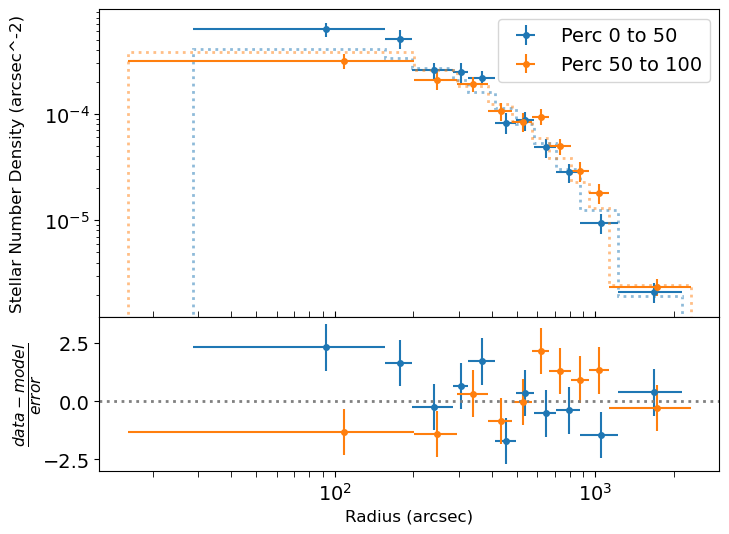

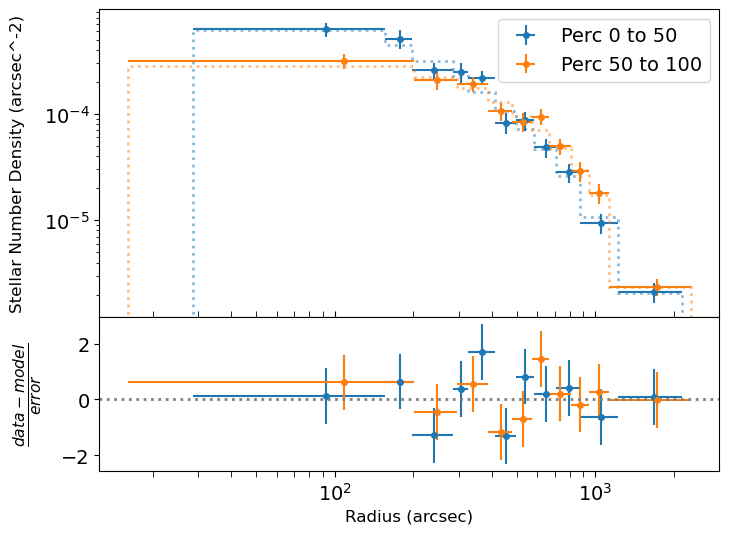

In [26]:
#these 2 functions are only needed here. The 2nd is from Prof. Uttley's github
def create_subsamples(clusterdf, quantity, percentile1, percentile2):

    if (quantity == 'PM'):
        clusterdf['Mean Proper Motion'] = np.sqrt(clusterdf['pmRA']**2 + clusterdf['pmDE']**2)
        low_perc = np.percentile(clusterdf['Mean Proper Motion'], percentile1)
        high_perc = np.percentile(clusterdf['Mean Proper Motion'], percentile2)
        subsample = clusterdf[(clusterdf['Mean Proper Motion'] >= low_perc) & (clusterdf['Mean Proper Motion'] <= high_perc)]
        return subsample
    elif (quantity == 'Gmag'):
        low_perc = np.percentile(clusterdf['Gmag'], percentile1)
        high_perc = np.percentile(clusterdf['Gmag'], percentile2)
        subsample = clusterdf[(clusterdf['Gmag'] >= low_perc) & (clusterdf['Gmag'] <= high_perc)]
        return subsample

def plot_spec_model_mult(ebins_list,cdens_list,cdens_err_list,cdens_model_list,emin,emax,resid_type,
                         legend_labels):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins_list - energy bin edges.
           cdens_list, cdens_err_list - counts density and its error.
           cdens_model_list - model counts density.
           emin, emax - minimum and maximum energy to be plotted
           resid_type - string, type of data vs model residuals, these can be: 
               ratio: data/model, resid: data-model, weighted resid: data-model/error
           legend_labels - list of labels for each dataset to use in legend, 
                   use None if no legend required'''
    
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    for i,ebins in enumerate(ebins_list):
        energies = (ebins[1:]+ebins[:-1])/2
        bwidths = np.diff(ebins)
        if legend_labels != None:
            label_txt = legend_labels[i]
        # Note that colours in the default Matplotlib colour cycle can be specified using strings 
        # 'C0'..'C9', which is useful for plotting the same colours for model and data.
        ax1.errorbar(energies, cdens_list[i], xerr=bwidths/2., yerr=cdens_err_list[i], 
                     color='C'+str(i), markersize=4, fmt='o', label=label_txt)
        model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights=cdens_model_list[i], 
                    density=False, histtype='step', color='C'+str(i), alpha=0.5, 
                                              linestyle='dotted', linewidth=2)
        if resid_type == 'ratio':
            ax2.errorbar(energies, cdens_list[i]/cdens_model_list[i], xerr=bwidths/2., 
                    yerr=cdens_err_list[i]/cdens_model_list[i], color='C'+str(i), markersize=4, fmt='o')
        elif resid_type == 'resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i]), xerr=bwidths/2., 
                    yerr=cdens_err_list[i], color='C'+str(i), markersize=4, fmt='o')
        elif resid_type == 'weighted resid':
            ax2.errorbar(energies, (cdens_list[i]-cdens_model_list[i])/cdens_err_list[i], xerr=bwidths/2., 
                    yerr=1.0, color='C'+str(i), markersize=4, fmt='o')
    ax2.set_xlabel("Radius (arcsec)", fontsize=12)
    ax1.set_ylabel("Stellar Number Density (arcsec^-2)", fontsize=12)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    if resid_type == 'ratio':
        ax2.set_ylabel("data/model", fontsize=12)
        ax2.axhline(1., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'resid':
        ax2.set_ylabel("data-model", fontsize=14)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    elif resid_type == 'weighted resid':
        ax2.get_yaxis().set_label_coords(-0.09,0.5)
        ax2.set_ylabel(r"$\frac{data-model}{error}$", fontsize=16)
        ax2.axhline(0., color='gray', linestyle='dotted', lw=2)
    ax1.tick_params(labelsize=14)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax2.tick_params(labelsize=14)
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    #ax2.set_xlim(emin,emax) # Strictly speaking we should only show the energy range 
    # where data is sampled, to avoid impression from model that the flux suddenly drops 
    # at the boundaries.
    ax1.legend(fontsize=14)
    plt.show()


Hogg_cluster = make_cluster(stars,'Hogg_4')
Hogg_Gmagsubsample1 = create_subsamples(Hogg_cluster,'Gmag',0,50)
Hogg_Gmagsubsample2 = create_subsamples(Hogg_cluster,'Gmag',50,100)
HoggGmag1_counts, HoggGmag1_edges = create_stardensprof(Hogg_Gmagsubsample1,50,0,'no title')
HoggGmag1_dens = HoggGmag1_counts/(np.pi*(np.diff(HoggGmag1_edges**2)))
HoggGmag1_errors = np.sqrt(HoggGmag1_counts)/(np.pi*(np.diff(HoggGmag1_edges**2)))
HoggGmag2_counts, HoggGmag2_edges = create_stardensprof(Hogg_Gmagsubsample2,50,0,'no title')
HoggGmag2_dens = HoggGmag2_counts/(np.pi*(np.diff(HoggGmag2_edges**2)))
HoggGmag2_errors = np.sqrt(HoggGmag2_counts)/(np.pi*(np.diff(HoggGmag2_edges**2)))
HoggParams1 = Parameters()
HoggParams2 = Parameters()
HoggParams1.add_many(('rho_01',rho_vals[0]),('r_c1',rc_vals[0]),('r_t1', rt_vals[0]),('c1',c_vals[0]),('rho_02',rho_vals[0],True,None,None,'rho_01'),('r_c2',rc_vals[0],True,None,None,'r_c1'),('r_t2',rt_vals[0],True,None,None,'r_t1'),('c2',c_vals[0]))
HoggParams2.add_many(('rho_01',rho_vals[0]),('r_c1',rc_vals[0]),('r_t1', rt_vals[0]),('c1',c_vals[0]),('rho_02',rho_vals[0]),('r_c2',rc_vals[0]),('r_t2',rt_vals[0],True,None,None,'r_t1'),('c2',c_vals[0]))

model = pl_model_mult
output_resid = True
xdata = [HoggGmag1_edges, HoggGmag2_edges]
ydata = [HoggGmag1_dens, HoggGmag2_dens]
yerrs = [HoggGmag1_errors, HoggGmag2_errors]
set_function = Minimizer(lmf_lsq_binresid_mult, HoggParams1, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_null = set_function.minimize(method = 'leastsq')
# To calculate the best-fitting model values, use the parameters of the best fit output
# from the fit, result.params and set output_resid=false to output a list of model y-values:
model_vals = lmf_lsq_binresid_mult(result_null.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Perc 0 to 50', 'Perc 50 to 100']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

model = pl_model_mult
output_resid = True
xdata = [HoggGmag1_edges, HoggGmag2_edges]
ydata = [HoggGmag1_dens, HoggGmag2_dens]
yerrs = [HoggGmag1_errors, HoggGmag2_errors]
set_function = Minimizer(lmf_lsq_binresid_mult, HoggParams2, fcn_args=(xdata, ydata, yerrs, model, output_resid),nan_policy='omit')
result_altern = set_function.minimize(method = 'leastsq')
model_vals = lmf_lsq_binresid_mult(result_altern.params,xdata,ydata,yerrs,model,output_resid=False)
# Now plot the data and model and residuals
legend_labels = ['Perc 0 to 50', 'Perc 50 to 100']
plot_spec_model_mult(xdata,ydata,yerrs,model_vals,10,200,'weighted resid',legend_labels)

The above are plots for Gmag selected subsamples of Hogg_4. In the first plot, all parameters of the king model for both subsamples are tied, while for the second, the normalization and core radius have been freed. We can see that the residuals are lower for the second model, indicating a better fit when the parameters are untied, further supporting the inference that the cluster is not well mixed on the basis of G-magnitude. 

*Eleonora*:
- Task 3
- the task is executed correctly but not complete. You needed the plots of all three clusters. Comments missing on how you splitted the subsamples (an histogram was needed here to justify the percentiles chosen). Missing comments on wilk's theorem, assumptions and validation;
- task completion 3/5 & task quality 3.5/5
- tot 6.5/10

**Assignment Task 4**

In [27]:
Hogg_cluster = make_cluster(stars,'Hogg_4')
Hogg_dist, Hogg_distpdf = d_prior(Hogg_cluster)
Hogg_varpmdist = varpm_normprior(Hogg_cluster)
Hogg_M = M_prior(Hogg_cluster)

/var/folders/k2/9ywfbnvs5w77jplb2svqcqcm0000gn/T/ipykernel_42264/2731124099.py:31: RuntimeWarning: divide by zero encountered in log
  logpos = np.log(Real_posterior_pdf)


In [28]:
Hogg_counts, Hogg_edges = create_stardensprof(Hogg_cluster,50,0,'no title')
Hoggparams = Parameters()
#variancePM = 0.1/mastorad
Hoggparams.add_many(('rho_0',0.013),('M',500),('varpm',0.01),('r_t',2000),('c',1e-7))

**Everything below this is mostly copied from Prof. Uttley's github**

In [29]:
def plexp_model(radius, params):
    '''
    King model modified for core radius in terms of mass and variance of proper motion.
    '''
    v = params.valuesdict()
    r_c = v['M']*G/(v['varpm'])
    if(isinstance(radius,float)):
        if(radius <= v['r_t']):
            return np.array((v['rho_0']*(1/(np.sqrt(1 + (radius/r_c)**2)) - 1/(np.sqrt(1 + (v['r_t']/r_c)**2)))**2 + v['c']))
        else:
            return np.array(v['c'])
    else:        
        rho_king = []
        for r in radius:
            if (r <=  v['r_t']):
                rho_king.append( v['rho_0']*(1/(np.sqrt(1 + (r/r_c)**2)) - 1/(np.sqrt(1 + (v['r_t']/r_c)**2)))**2 + v['c'] )
            else :
                rho_king.append( v['c'] )   
        return np.array(rho_king)

def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sts.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))

def lmf_poissll(params,xdata,ydata,model,output_ll=True):
    '''lmfit objective function to calculate and return total negative Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin widths
                ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + LogLikelihood_Pois(ymodel,ydata[i])
        return poissll
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

In [30]:
#params.add('gamma',value=-1.5,vary=True)
model = plexp_model
output_ll = True
xdata = [Hogg_edges]
ydata = [Hogg_counts]
set_function = Minimizer(lmf_poissll, Hoggparams, fcn_args=(xdata, ydata, model, output_ll),
                         nan_policy='omit',calc_covar=True)
poiss_result = set_function.scalar_minimize(method='Nelder-Mead') # We specify the method for completeness, 
                                                            # but Nelder-Mead is the default
report_fit(poiss_result)
print("Summed log-likelihood = ",-1*poiss_result.residual)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 814
    # data points      = 1
    # variables        = 5
    chi-square         = 6661.24177
    reduced chi-square = 6661.24177
    Akaike info crit   = 18.8040612
    Bayesian info crit = 8.80406120
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    rho_0:  2.21084843 (init = 0.013)
    M:     -54701.7855 (init = 500)
    varpm: -0.21487102 (init = 0.01)
    r_t:    2417.99683 (init = 2000)
    c:     -2.0776e-05 (init = 1e-07)
Summed log-likelihood =  [-81.61643079]


In [31]:
best_par_list = []
for par in ['rho_0','M','varpm','r_t','c']:
    best_par_list.append(Hoggparams[par].value)
best_par=np.array(best_par_list) # needs to be an array so we can use it for calculations
ndim, nwalkers = 5, 100  # The number of parameters and the number of walkers (we follow the 
# emcee example and use 100)
output_ll=True
pos = [best_par + 0.01*best_par*sts.norm.rvs(size=ndim) for i in range(nwalkers)]  # we spread the 
# walkers around the MLEs with a standard deviation equal to 1 per cent of the MLE value

In [32]:
#copied from Prof. Uttley's github
def lmf_poissll_emcee(params,xdata,ydata,model,prior_model,output_ll=True):
    '''lmfit-style objective function to calculate and return total Poisson log-likelihood or model 
        y-values for binned data where the xdata are the contiguous (i.e. no gaps) input bin edges and 
        ydata are the counts (not count densities) per bin.
        Inputs: params - name of lmfit Parameters object set up for the fit.
                xdata, ydata - lists of 1-D arrays of x (must be bin edges not bin centres) 
                and y data and y-errors to be fitted.
                    E.g. for 2 data sets to be fitted simultaneously:
                        xdata = [x1,x2], ydata = [y1,y2], yerrs = [err1,err2], where x1, y1, err1
                        and x2, y2, err2 are the 'data', sets of 1-d arrays of length n1 (n1+1 for x2
                        since it is bin edges), n2 (n2+1 for x2) respectively, 
                        where n1 does not need to equal n2.
                    Note that a single data set should also be given via a list, i.e. xdata = [x1],...
                model - the name of the model function to be used (must take params as its input params and
                        return the model y counts density array for a given x-value array).
                output_resid - Boolean set to True if the lmfit objective function (total -ve 
                        log-likelihood) is required output, otherwise a list of model y-value arrays 
                        (corresponding to the input x-data list) is returned.
        Output: if output_resid==True, returns the total negative log-likelihood. If output_resid==False, 
                returns a list of y-model counts density arrays (one per input x-array)'''
    if output_ll == True:
        poissll = 0
        for i, xvals in enumerate(xdata):  # loop through each input dataset to sum negative log-likelihood
                # We can re-use our model binning function here, but the model then needs to be converted into 
                # counts units from counts density, by multiplying by the bin widths
                ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
                # Then obtain negative Poisson log-likelihood for data (in counts units) vs the model 
                poissll = poissll + (-1*LogLikelihood_Pois(ymodel,ydata[i]))
        poissll_prior = poissll + prior_model(params)     
        if not np.isfinite(poissll_prior):
            return -np.inf
        else:
            return poissll_prior
    else:
        ymodel = []
        for i, xvals in enumerate(xdata): # record list of model y-value arrays, one per input dataset
            ymodel.append(model_bin(xdata[i],model,params))
        return ymodel

def LogLikelihood_Pois(model_counts, counts): 
    '''Calculate the negative Poisson log-likelihood for a model vs counts data. 
       Inputs:
           model_counts - array of predicted model counts per bin
           counts - data: observed counts per bin.
        Outputs: the negative Poisson log-likelihood'''
    pd = sts.poisson(model_counts) #we define our Poisson distribution
    return -1*np.sum(pd.logpmf(counts))
        
def plexp_model_emcee(radius, pars):
    '''
    King model function modified for core radius in terms of mass and variance of proper motion.
    '''
    (rho_0,M,varpm,r_t,c) = pars
    r_c = M*G/varpm
    if(isinstance(radius,float)):
        if(radius <= r_t):
            return np.array((rho_0*(1/(np.sqrt(1 + (radius/r_c)**2)) - 1/(np.sqrt(1 + (r_t/r_c)**2)))**2 + c))
        else:
            return np.array(c)
    else:        
        rho_king = []
        for r in radius:
            if (r <=  r_t):
                rho_king.append( rho_0*(1/(np.sqrt(1 + (r/r_c)**2)) - 1/(np.sqrt(1 + (r_t/r_c)**2)))**2 + c )
            else :
                rho_king.append(c)   
        return np.array(rho_king)
    
def plexp_logprior(pars):
    '''
    Returns the combined log-prior for the given input pars. 
    '''
    (rho_0,M,varpm,r_t,c) = pars
    #Mass =  -M_prior(Hogg_cluster)*np.ones((604,1))
    #distance, distpdf = -np.array(d_prior(Hogg_cluster))
    #PMvariance = -np.array(varpm_normprior(Hogg_cluster))
    if ((M <= 0) | (r_t <= 0) | (rho_0 <= 0) | (c<=0)):
        return -np.inf
    else:
        #return (distpdf+PMvariance)
        return 0

In [33]:
model = plexp_model_emcee
prior_model = plexp_logprior
sampler = emcee.EnsembleSampler(nwalkers, ndim, lmf_poissll_emcee,args=(xdata,ydata,model,prior_model,output_ll))
sampler.run_mcmc(pos, 10000)

np.save('King1000_samplerchain',sampler.chain)

emcee: Exception while calling your likelihood function:
  params: [1.16033191e+00 4.75827196e+07 4.43893728e+02 1.09737928e+07
 2.24272588e-03]
  args: ([array([  16.03132986,  108.84682527,  155.25457298,  201.66232068,
        248.07006838,  294.47781609,  340.88556379,  387.2933115 ,
        433.7010592 ,  480.1088069 ,  526.51655461,  572.92430231,
        619.33205002,  665.73979772,  758.55529313,  804.96304083,
        897.77853624, 1037.00177935, 1176.22502246, 1361.85601328,
       2336.41871506])], [array([28., 36., 47., 34., 38., 32., 43., 37., 20., 30., 25., 28., 24.,
       35., 24., 26., 25., 23., 21., 28.])], <function plexp_model_emcee at 0x386d54540>, <function plexp_logprior at 0x386b75440>, True)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/eleonoracaruso/anaconda3/lib/python3.11/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/k2/9ywfbnvs5w77jplb2svqcqcm0000gn/T/ipykernel_42264/2042881604.py", line 27, in lmf_poissll_emcee
    ymodel = model_bin(xdata[i],model,params)*np.diff(xdata[i])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/k2/9ywfbnvs5w77jplb2svqcqcm0000gn/T/ipykernel_42264/3382211457.py", line 14, in model_bin
    ymod[i], ymoderr = spint.quad(lambda x: 2*np.pi*x*model(x, params),xbins[i],xbins[i+1])
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/eleonoracaruso/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py", line 465, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [45]:
#file = np.load('./gopalanraghavan_LATE_410629_10311475_10000Samples.npy')
#print(file)

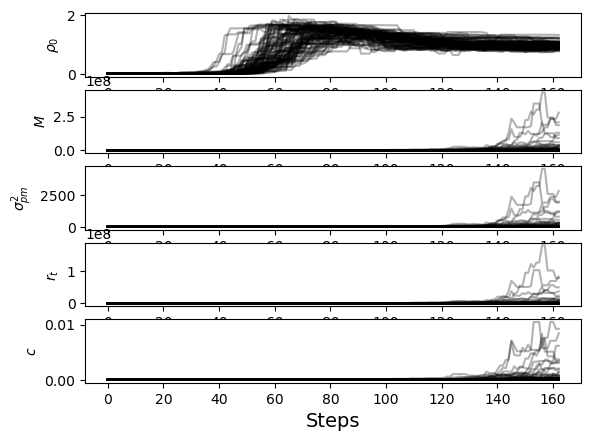

In [34]:
labels_list = [r'$\rho_{0}$',r'$M$',r'$\sigma_{pm}^2$',r'$r_t$',r'$c$'] # labels for our plots

nsteps = 1000  # How many steps to plot. We plot fewer steps since we include all walkers.
fig = plt.figure()
fig.clf()
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    for k in range(nwalkers):
        ax.plot(sampler.chain[k,:nsteps,j],color='black',alpha = 0.3)
    ax.set_ylabel(labels_list[j], fontsize = 10)
plt.xlabel('Steps', fontsize = 14)
plt.savefig('King1000.png')

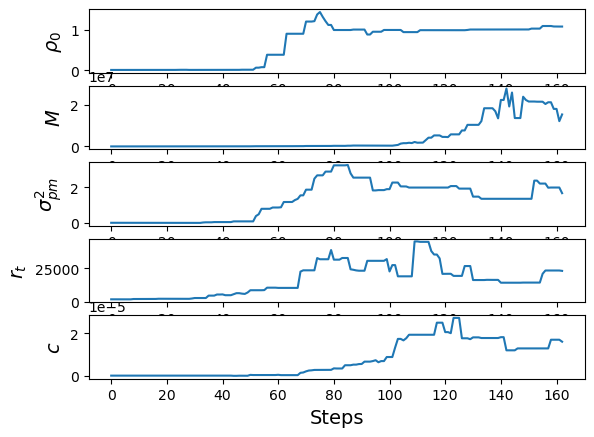

In [35]:
nsteps = 1000 # How many steps to plot
rng = np.random.default_rng()  # Set up a random number generator to select a random walker
fig = plt.figure()
fig.clf()
for j in range(ndim):
    ax = fig.add_subplot(ndim,1,j+1)
    ax.plot(sampler.chain[rng.integers(nwalkers),:nsteps,j]) # plot the chain for a random walker
    ax.set_ylabel(labels_list[j], fontsize = 14)
plt.xlabel('Steps', fontsize = 14)
plt.savefig('King1000.png')

In [36]:
tau = sampler.get_autocorr_time()  # include parameter quiet=False if the function fails due to 
                                    # chains not being long enough
print("Autocorrelation scales (in steps) for rho_0, M, varPM, r_t and c: ",tau)

def plot_chains_powspec(chain_in,labels): 
    powspec = np.sum(np.abs(scipy.fft.fft(chain_in,axis=1))**2,axis=0)
    freq = scipy.fft.fftfreq(len(chain_in[0,:,0]))
    plt.figure()
    for i in range(ndim):
        plt.plot(1/freq[1:len(freq)//2],
                 powspec[1:len(freq)//2,i]/np.mean(powspec[1:len(freq)//2,i]),label=labels[i])
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Chain length scale (steps)', fontsize = 14)    
    plt.ylabel(r'Normalised power density', fontsize = 14)
    plt.legend(fontsize=14)
    plt.savefig('King1000autocorr.png')
    plt.show()
    return

plot_chains_powspec(sampler.chain,labels_list)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3;
tau: [18.05378109 19.79198144 18.1914884  16.21588753 19.79852187]

In [37]:
# Plot a corner plot using thin=10 to reduce the density for visual appearance
flat_samples = sampler.get_chain(discard=500, thin=10, flat=True) 
fig = corner.corner(flat_samples, labels=labels_list, label_kwargs={"fontsize": 14})#, truths=result.x)
plt.savefig('Corner10000.png')
plt.show()

/Users/eleonoracaruso/anaconda3/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (1) than draws (0). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


AssertionError: I don't believe that you want more dimensions than samples!

In [38]:
flat_samples_full = sampler.get_chain(discard=500, flat=True)
print("Median and 1-sigma errors")
for i in range(ndim):
    mcmc = np.percentile(flat_samples_full[:, i], [15.85, 50, 84.15])
    q = np.diff(mcmc)
    txt = "{3} = {0:.3f} -{1:.3f}/+ {2:.3f}" # This formatting rounds to 3 decimal places.
    txt = txt.format(mcmc[1], q[0], q[1], ['rho_0','M','varPM','r_t','c'][i])
    print(txt)

Median and 1-sigma errors


IndexError: index -1 is out of bounds for axis 0 with size 0

**Comments on Task 4**
<br>
For this task, I have selected the cluster Hogg_4. Above, I have created functions that return the priors for distance, mass and proper motion variance, which are needed for the Bayes' theorem relation between core radius, mass, G and variance of proper motion of the cluster. In my submission, I have attached numpy files and pngs from 2 runs. 
For the ones with 100 in the name, I ran the MCMC sampler for 100 steps, with the lines in plexp_logprior for distance and variance priors uncommented (and if not np.isfinite(poissll_prior.any()) in lmf_poissll_emcee. There is a constant runtime warning due to a divide by zero in the distance logpdf, so I was only able to run it for 100 steps due to a lack of time. In this case, we see that the mass of the cluster from the corner plot is about 500 solar masses. However, since there are only 100 steps, we cannot comment much as the walkers have not moved much from their starting point (also seen from autocorrelation nan outputs). 
For the files with 10000 in the name, I ran MCMC with a constant prior and 10000 steps (there is no need for the .any() in lmf_poissll_emcee in this case). However, this led to a heavy divergence of the parameters from their starting point and sparse corner plots. The walkers have significantly moved, but did not converge in the parameter space. The mass is of the order 1e210 solar masses, which is highly unrealistic. This is likely due to the bad prior estimation. With a more realistic prior, better starting point (the Nelder-Mead did not yield usable results, so I had to use my own estimates) and more robust unit handling, we may be able to get a good estimation of cluster mass. This would of course require a significant step count and burn-in time.


*Eleonora*:
- Task 4
- I cannot really run any of your code for task4 but I do see the plots you uploaded. You are missing the correct definition of priors for sigma2 and distance and you don't fit the data to get the initial parameters; From your plots looks like the parameters are not rerally converging (probably due to wrong priors). The final results on M are also off;
- 5.5/10